In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import pprint

import networkx as nx

### Reading data frames into dictionary

In [26]:
def reading_filenames(input_dir):
    files = [f for f in os.listdir(input_dir) if f.endswith('.tsv') or f.endswith('.txt')]

    return files

In [27]:
data_folder = 'data/wikispeedia_paths-and-graph/'
file_names = reading_filenames(data_folder)

In [28]:
print(file_names)

['paths_unfinished.tsv', 'links.tsv', 'categories.tsv', 'paths_finished.tsv', 'shortest-path-distance-matrix.txt', 'articles.tsv']


In [29]:
dataframes = {}

#Reading files in dictionary
for file in file_names:
    try:
        if file.endswith('.tsv'):
            df = pd.read_csv(data_folder + file, sep='\t', comment='#', header = None, encoding="utf-8")
        else:
            df = pd.read_csv(data_folder + file, sep=',', comment='#', header = None, encoding="utf-8")
        
        dataframes[file.split('.')[0]] = df
    except pd.errors.ParserError as e:
        print(f"Could not parse {file}: {e}")

In [30]:
print(dataframes.keys())

dict_keys(['paths_unfinished', 'links', 'categories', 'paths_finished', 'shortest-path-distance-matrix', 'articles'])


### Links data
Cleaning up link data

In [31]:
dataframes['links'] = dataframes['links'].rename(columns={0: "linkSource", 1: "linkTarget"})

In [32]:
dataframes["links"]["linkSource"] = dataframes["links"]["linkSource"].apply(unquote)
dataframes["links"]["linkTarget"] = dataframes["links"]["linkTarget"].apply(unquote)

In [33]:
dataframes['links'].head(10)

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
5,Áedán_mac_Gabráin,Isle_of_Man
6,Áedán_mac_Gabráin,Monarchy
7,Áedán_mac_Gabráin,Orkney
8,Áedán_mac_Gabráin,Picts
9,Áedán_mac_Gabráin,Scotland


In [34]:
#Printing wikipages with most links
source_counts = dataframes["links"]['linkSource'].value_counts()
print(source_counts.iloc[0:10])


linkSource
United_States                                294
Driving_on_the_left_or_right                 255
List_of_countries                            244
List_of_circulating_currencies               236
List_of_sovereign_states                     216
Africa                                       212
List_of_countries_by_system_of_government    207
Lebanon                                      192
Interpol                                     191
Armenia                                      186
Name: count, dtype: int64


<Axes: >

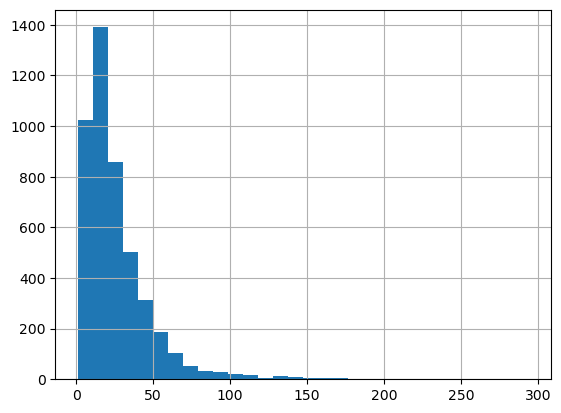

In [35]:
#Plotting distribution of links on wikipages
source_counts.hist(bins = 30)

In [36]:
#Printing wikipages with most links to them
target_counts = dataframes["links"]['linkTarget'].value_counts()
print(target_counts.iloc[0:10])

linkTarget
United_States       1551
United_Kingdom       972
France               959
Europe               933
World_War_II         751
England              751
Germany              743
India                611
English_language     598
London               587
Name: count, dtype: int64


<Axes: >

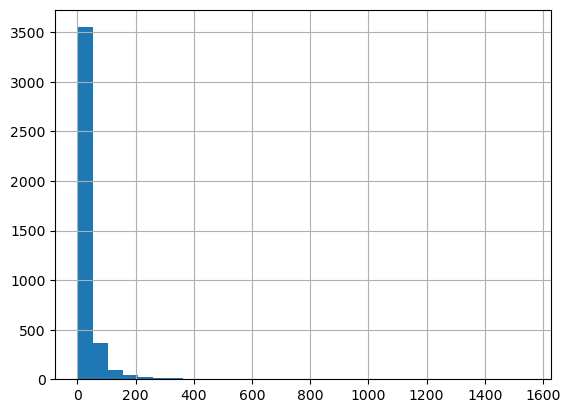

In [37]:
#Plotting distribution of links to wikipages
target_counts.hist(bins = 30)

### Categories data
Cleaning up categories data

In [38]:
#Renaming columns
dataframes['categories'] = dataframes['categories'].rename(columns={0: "article", 1: "category"})

In [39]:
#Decoding article names
dataframes["categories"]["article"] = dataframes["categories"]["article"].apply(unquote)

In [40]:
#Splitting categories into sub categories
split_columns = dataframes["categories"]['category'].str.split('.', expand=True)

#Dropping first column which only contains the word subject
split_columns = split_columns.drop(0, axis=1)
split_columns.head()


,1,2,3
0,History,British_History,British_History_1500_and_before_including_Roma...
1,People,Historical_figures,None
2,Countries,None,None
3,Geography,European_Geography,European_Countries
4,People,Artists,None


In [41]:
#Joining with original dataframe
dataframes["categories"] = dataframes["categories"].join(split_columns)

In [42]:
dataframes["categories"].head(20)

,article,category,1,2,3
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,subject.People.Historical_figures,People,Historical_figures,None
2,Åland,subject.Countries,Countries,None,None
3,Åland,subject.Geography.European_Geography.European_...,Geography,European_Geography,European_Countries
4,Édouard_Manet,subject.People.Artists,People,Artists,None
5,Éire,subject.Countries,Countries,None,None
6,Éire,subject.Geography.European_Geography.European_...,Geography,European_Geography,European_Countries
7,Óengus_I_of_the_Picts,subject.History.British_History.British_Histor...,History,British_History,British_History_1500_and_before_including_Roma...
8,Óengus_I_of_the_Picts,subject.People.Historical_figures,People,Historical_figures,None
9,€2_commemorative_coins,subject.Business_Studies.Currency,Business_Studies,Currency,None


In [43]:
print(dataframes["categories"][1].unique())

['History' 'People' 'Countries' 'Geography' 'Business_Studies' 'Science'
 'Everyday_life' 'Design_and_Technology' 'Music' 'IT'
 'Language_and_literature' 'Mathematics' 'Religion' 'Art' 'Citizenship']


### Creating graph plot over links and giving color by subject

Tried to create a connected graph visualization. Not very happy with it! Unsure if this is a good way to do it. \
Ideas:
- Would be cool with a visualization that shows all pages with 1 link, 2 links, 3 links ... be removed 
- Can we look at the major hubs only?
- Something density based?? 


In [44]:
G = nx.from_pandas_edgelist(dataframes["links"], source='linkSource', target='linkTarget') #.iloc[0:2000]

In [45]:
#Note: Make so that articles with several subjects have a special color??
color_map = {category: color for category, color in zip(dataframes["categories"][1].unique(), plt.cm.tab10.colors)}
print(color_map)

node_colors = []

for node in G.nodes:

    result = dataframes['categories'][dataframes['categories']['article'] == node][1]

    if not result.empty:
        category = result.values[0]  # Get the first category value
        
        node_colors.append(color_map.get(category, "grey"))
    else:
        node_colors.append("grey")
    

{'History': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'People': (1.0, 0.4980392156862745, 0.054901960784313725), 'Countries': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'Geography': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'Business_Studies': (0.5803921568627451, 0.403921568627451, 0.7411764705882353), 'Science': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), 'Everyday_life': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), 'Design_and_Technology': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), 'Music': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), 'IT': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)}


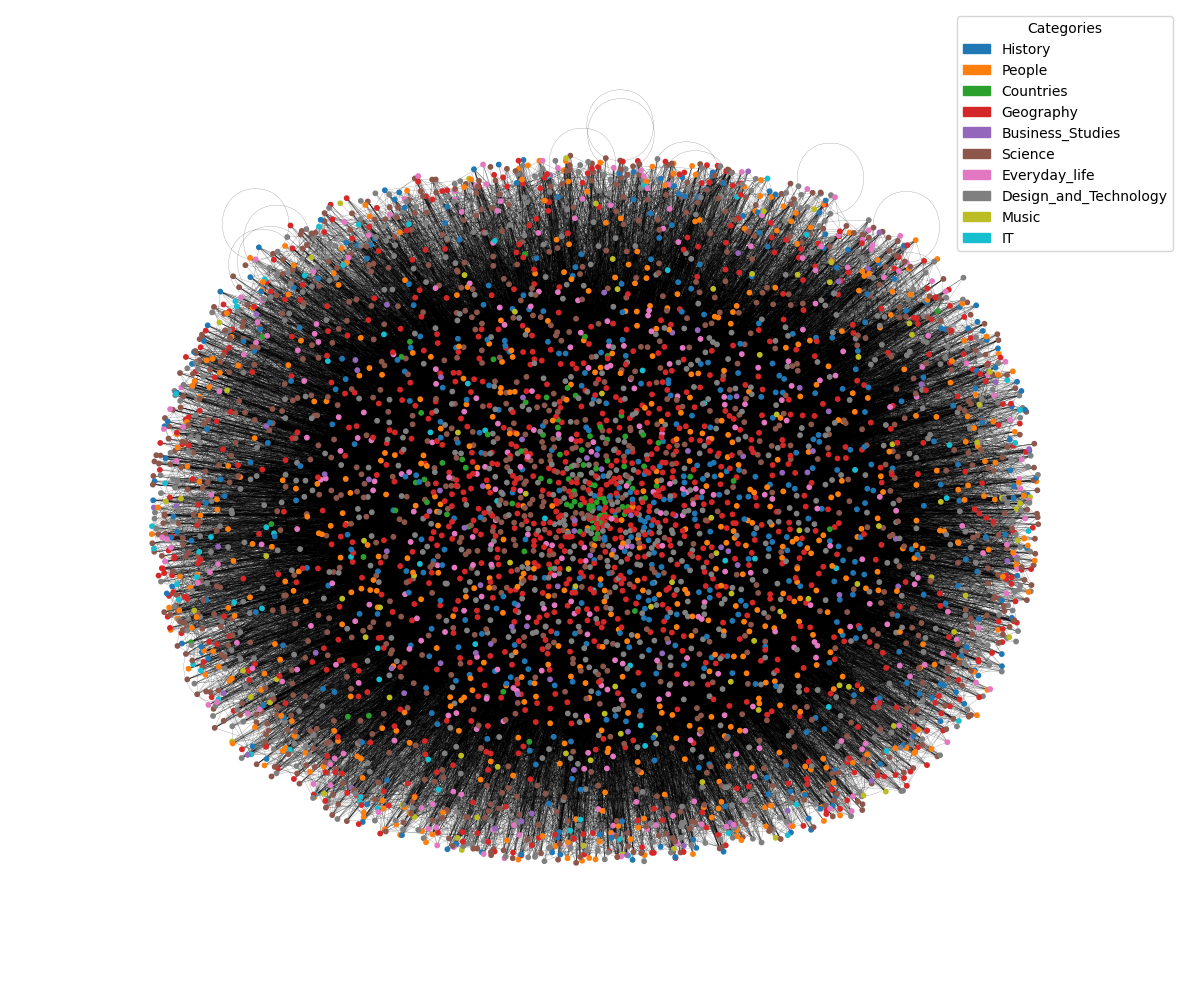

In [305]:
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed

# Adjust the spring layout
pos = nx.spring_layout(G, seed=10, k=0.5)  # Increase 'k' to space out nodes more

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_colors)  # Increase node size for visibility

# Edges
nx.draw_networkx_edges(G, pos, width=0.1)  # Increase edge width for better visibility

legend_handles = [mpatches.Patch(color=color_map[category], label=category) for category in color_map]

# Add legend to the plot
plt.legend(handles=legend_handles, title="Categories", loc='upper right')
# Layout adjustments
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()

plt.show()

### Handling paths

In [46]:
# Renaming columns in paths_finished
dataframes["paths_finished"] = dataframes["paths_finished"].rename(columns={0: "hashedIpAddress",
                                                                             1: "timestamp", 
                                                                             2: "durationInSec", 
                                                                             3: "path", 
                                                                             4: "rating"})
# Adds target to paths_finished
dataframes["paths_finished"]["target"] = dataframes["paths_finished"]["path"].str.split(";").str[-1]

# Decode percentage-encoded characters in path in paths_finished
dataframes["paths_finished"]["path"] = dataframes["paths_finished"]["path"].apply(unquote)

dataframes["paths_finished"].head()


,hashedIpAddress,timestamp,durationInSec,path,rating,target
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy


In [47]:
# Renaming columns in paths_unfinished
dataframes["paths_unfinished"] = dataframes["paths_unfinished"].rename(columns={0: "hashedIpAddress",
                                                                             1: "timestamp", 
                                                                             2: "durationInSec", 
                                                                             3: "path", 
                                                                             4: "target",
                                                                             5: "type"})

# Decode percentage-encoded characters in path in paths_unfinished
dataframes["paths_unfinished"]["path"] = dataframes["paths_unfinished"]["path"].apply(unquote)

dataframes["paths_unfinished"].head(20)

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
5,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout
6,486bb79910fe9dd2,1297101660,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,timeout
7,6d136e371e42474f,1297102070,175,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,restart
8,6d136e371e42474f,1297102100,19,Logic,Moon_landing,restart
9,6d136e371e42474f,1297104110,2006,Logic;Computer_science;Science;Physical_scienc...,Moon_landing,timeout


In [48]:
# Displays the amount of ratings for paths_finished
dataframes["paths_finished"]["rating"].value_counts(dropna=False)

# TODO: How do we handle all the NaN values? (Sampling, prediction?)

rating
NaN    22817
2.0     8792
1.0     8542
3.0     7261
4.0     2748
5.0     1158
Name: count, dtype: int64

In [49]:
# Displays the amount of each type for paths_unfinished
dataframes["paths_unfinished"]["type"].value_counts(dropna=False)

# TODO: Should timeouts counts as hard?

type
restart    15552
timeout     9323
Name: count, dtype: int64

In [50]:
# Displays the most visited articles in paths_finished
article_freq_finish = dataframes["paths_finished"]["path"].str.split(";").explode().to_frame().rename(columns={"path": "article"})
article_freq_finish = article_freq_finish.merge(right=dataframes["categories"][["article", 1]], on="article", how="left").rename(columns={1: "subject"})

article_freq_finish["article"].value_counts(dropna=False)

# TODO: Add Article category

article
<                                  20561
United_States                      17792
United_Kingdom                     11712
Europe                              4362
Germany                             3538
                                   ...  
United_States_Numbered_Highways        1
Psittacosaurus                         1
Póvoa_de_Varzim                        1
Antonín_Dvořák                         1
Novelty_(locomotive)                   1
Name: count, Length: 4170, dtype: int64

In [51]:
# Displays the most visited article types in paths_finished 
article_freq_finish["subject"].value_counts(dropna=False)

subject
Geography                  110287
Science                     84676
Countries                   44450
History                     32900
Everyday_life               28556
People                      23013
NaN                         20631
Citizenship                 19585
Language_and_literature     13363
Design_and_Technology       11166
Religion                    10802
IT                           8840
Business_Studies             5569
Music                        4610
Mathematics                  3355
Art                          2178
Name: count, dtype: int64

In [52]:
# Displays the most visited articles in paths_unfinished
article_freq_unfinish = dataframes["paths_unfinished"]["path"].str.split(";").explode().to_frame().rename(columns={"path": "article"})
article_freq_unfinish = article_freq_unfinish.merge(right=dataframes["categories"][["article", 1]], on="article", how="left").rename(columns={1: "subject"})

article_freq_unfinish["article"].value_counts(dropna=False)

# TODO: Add Article category

article
<                           12907
United_States                7106
United_Kingdom               4272
Theatre                      1864
France                       1262
                            ...  
Newcastle_upon_Tyne             1
Battle_of_Rennell_Island        1
ABO_blood_group_system          1
Gothenburg                      1
GlaxoSmithKline                 1
Name: count, Length: 4062, dtype: int64

In [53]:
# Displays the most visited article types in paths_unfinished 
article_freq_unfinish["subject"].value_counts(dropna=False)

subject
Geography                  37806
Science                    27760
Countries                  15159
NaN                        12928
Everyday_life              11786
History                    10960
Citizenship                 8001
People                      7570
Language_and_literature     6858
Design_and_Technology       4640
Religion                    3903
IT                          2944
Business_Studies            2284
Music                       1706
Mathematics                 1025
Art                          953
Name: count, dtype: int64